In [34]:
import numpy as np
import pandas as pd
import torch
import tqdm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

In [2]:
from cbbstats.data import StatsDataset, columns, preprocess_df
from cbbstats.models import FFN

In [3]:
df = pd.read_json('data/2011-2020_boxscores.json.gz')
df = preprocess_df(df)

In [4]:
df = df.dropna(subset=['OPP_TEAM'])

In [5]:
opp_df = df.rename(columns={'TEAM': 'OPP_TEAM', 'OPP_TEAM': 'TEAM'})

In [6]:
df = df.set_index(['DATE', 'TEAM', 'OPP_TEAM'])
opp_df = opp_df.set_index(['DATE', 'TEAM', 'OPP_TEAM'])

In [7]:
stats = pd.merge(
    df, 
    opp_df,
    how='left', left_index=True, right_index=True, 
    suffixes=("", "_OPP")
)

In [8]:
stats = stats.dropna()

In [9]:
feat_scaler = StandardScaler()
feat_scaler.fit(stats[columns.MODEL_INPUTS].values)

target_scaler = StandardScaler()
target_scaler.fit(stats[['y']].values)

StandardScaler()

In [59]:
dump(feat_scaler, 'models/second-try.feat_scaler.bin', compress=True)
dump(target_scaler, 'models/second-try.target_scaler.bin', compress=True)

['models/second-try.target_scaler.bin']

In [11]:
x = feat_scaler.transform(stats[columns.MODEL_INPUTS].values)
y = target_scaler.transform(stats[['y']].values)

In [12]:
ds = StatsDataset(x, y)

In [13]:
n_train = int(len(ds)*0.9)
n_test = len(ds) - n_train

In [14]:
train_ds, test_ds = torch.utils.data.dataset.random_split(ds, [n_train, n_test])

In [15]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=False)

In [47]:
model = FFN(hidden_sizes=[64], dropout=0.1)

In [48]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [50]:
model.fit(train_loader, 25, test_loader, loss, optimizer)

Epoch 25 Validation Loss: 0.707: 100%|████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 178.32it/s]


In [32]:
torch.save(model, 'models/second-try.pt')

In [52]:
test_preds = target_scaler.inverse_transform(model.predict(test_loader))
test_targets = target_scaler.inverse_transform([[y.item()] for x, y in test_ds])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 242.68it/s]


In [53]:
import plotly.express as px

In [54]:
plot_df = pd.DataFrame()
plot_df[['preds']] = test_preds
plot_df[['targets']] = test_targets

In [55]:
np.sqrt(mse(test_targets, test_preds)), r2(test_targets, test_preds)

(12.215171668469003, 0.29207668188782177)

In [58]:
(np.sign(test_preds) == np.sign(test_targets))

array([[ True],
       [False],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

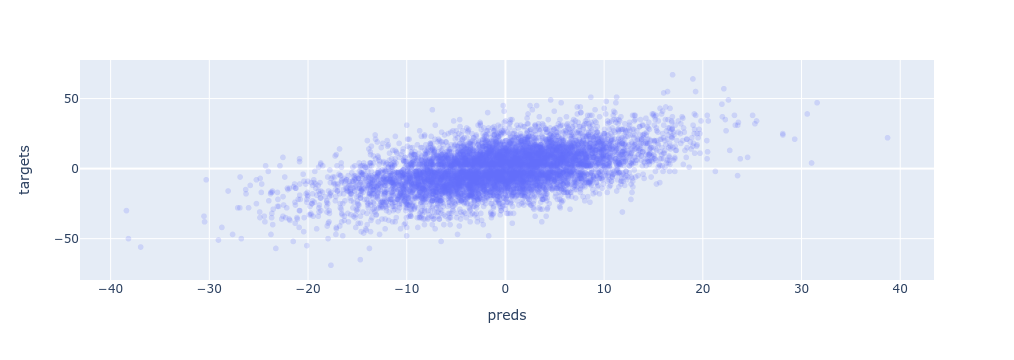

In [32]:
px.scatter(plot_df, x='preds', y='targets', render_mode='webgl', opacity=0.2)